# Arytmetyka i algebra dla kryptografii

In [19]:
import math
import random
import matplotlib.pyplot as plt

## Testowanie pierwszości

Głównym tematem dzisiejszych laboratoriów będą **testy pierwszości** (primality tests), tj. algorytmy sprawdzania, czy zadana liczba jest liczbą pierwszą. Jakkolwiek istnieją asymptotycznie wydajne *deterministyczne* algorytmy rozwiązujące ten problem, w praktyce są one znacznie wolniejsze i bardziej skomplikowane od algorytmów *probabilistycznych*, na których się skupimy.

Jako referencyjny test pierwszości wykorzystamy prosty algorytm sprawdzający po kolei, czy liczby naturalne z zakresu $2,...,\lfloor\sqrt{n}\rfloor$ są dzielnikami $n$.

In [20]:
def prime_naive(n):
    if n < 2:
        return False

    m = math.isqrt(n)
    for i in range(2, m + 1):
        if n % i == 0:
            return False

    return True

By przyspieszyć nieco obliczenia w pozostałych ćwiczeniach, możemy zapamiętać wyniki dla pewnego początkowego zakresu liczb.

In [21]:
SIZE = 1000000
IS_PRIME = [prime_naive(n) for n in range(SIZE)]
PRIMES = [n for n in range(SIZE) if IS_PRIME[n]]

In [22]:
def prime_ref(n):
    """
    Referencyjny test pierwszości, z którym porównywać będziemy inne metody.
    """
    if n < SIZE:
        return IS_PRIME[n]
    else:
        return prime_naive(n)

### Test Fermata

Małe twierdzenie Fermata mówi, że jeśli $p$ jest liczbą pierwszą i $0 < a < p$, to $a^{p-1} \equiv 1 \pmod p$. Fakt ten stanowi podstawę *testu pierwszości Fermata*. W teście tym by sprawdzić, czy dane $n$ jest liczbą pierwszą, losujemy $0 < a < p$ i sprawdzamy, czy $a^{n-1} \equiv 1 \pmod n$. Jeśli nie, możemy z pewnością stwierdzić, że $n$ nie jest liczbą pierwszą. Jeśli tak, to $n$ może być liczbą pierwszą (ale nie musi).

Test Fermata nie daje nam pewności, że liczba, która go pomyślnie przeszła jest liczbą pierwszą. By zwiększyć wiarygodność wyniku pozytywnego, możemy wykonać więcej niż jedną iterację, tzn. wylosować kilka wartości $a$. Jeśli test nie przejdzie dla którejkolwiek z nich, $n$ nie jest liczbą pierwszą.

#### Zadanie 1

1. Zaimplementuj test Fermata. Do obliczania $a^k \pmod N$ należy wykorzystać wbudowaną funkcję `pow`, np. `pow(a, k, mod=N)`
2. Przeanalizuj wyniki testu Fermata z jedną iteracją dla wszystkich liczb naturalnych z zakresu $\{1,\ldots,10^6\}$. Ile jest fałszywych wyników pozytywnych, tj. liczb złożonych, dla których test się powiódł? Czy sa jakieś fałszywe wyniki negatywne, tj. liczby pierwsze, dla których test się nie powiódł?
3. Ile iteracji potrzeba, by mieć rozsądne szanse na zero niepoprawnych wyników w teście z punktu 2?
4. Narysuj wykres przedstawiający ilość błędnie sklasyfikowanych liczb w teście z punktu 2 w zależności od liczby iteracji testu Fermata. Użyj skali logarytmicznej dla osi pionowej.

#### Rozwiązanie

In [30]:
def fermat_test(n, iter):
    for _ in range(iter):
        a = random.randint(1, n - 1)
        apow_mod_n = pow(a, n - 1, mod=n)
        if apow_mod_n != 1:
            return False
    return True 

def get_fermat_test_errors(iter):
    false_positives = 0
    false_negatives = 0

    for i in range(2, SIZE):
        test_positive = fermat_test(i, iter)
        if not prime_ref(i) and test_positive:
            false_positives += 1
        elif prime_ref(i) and not test_positive:
            false_negatives += 1
    
    return false_positives, false_negatives

false_positives, false_negatives = get_fermat_test_errors(1)

print("Wyniki dla jednej iteracji testu:")
print(f"Fałszywe pozytywy: {false_positives}")
print(f"Fałszywe negatywy: {false_negatives}")

errors = []
for i in range(1, 40):
    false_positives, _ = get_fermat_test_errors(i)
    errors.append(false_positives)

plt.plot(errors, marker="o")

plt.yscale('log')

plt.title('Zależność błędów od liczby iteracji testu Fermata')
plt.xlabel('Liczba iteracji')
plt.ylabel('Liczba błędów')

plt.grid()

plt.legend()
plt.show()

Wyniki dla jednej iteracji testu:
Fałszywe pozytywy: 444
Fałszywe negatywy: 0


KeyboardInterrupt: 

30 iteracji daje rozsądne szanse na zero niepoprawnych wyników.

### Test Millera-Rabina

W teście Millera-Rabina poza małym twierdzeniem Fermata wykorzystujemy również inną własność liczb pierwszych: jeśli $n$ jest liczbą pierwszą, to $\mathbb{Z}/n\mathbb{Z}$ jest ciałem, a więc wielomiany stopnia $q$ mają w nim co najwyżej $q$ pierwiastków. W szczególności, jeśli $n$ jest liczbą pierwszą $\neq 2$, równanie $x^2 \equiv 1 \pmod n$ ma dokładnie dwa rozwiązania: $1$ oraz $-1 \equiv n - 1 \pmod n$.

Niech $n - 1 = 2^s d$, $d$ nieparzyste. Z małego twierdzenia Fermata wiemy, że dla $0 < a < n$ zachodzi $a^{2^s d} = a^{n-1} \equiv 1 \pmod n$. Jako, że $a^{2^s d} = \left(a^{2^{s-1}d}\right)^2$, to $a^{2^{s-1}d}$ jest jednym z rozwiązań równania $x^2 \equiv 1 \pmod n$, a zatem są dwie możliwości:

- $a^{2^{s-1}d} \equiv -1 \pmod n$, albo
- $a^{2^{s-1}d} \equiv 1 \pmod n$

Aplikując powyższe rozumowanie do przypadku $a^{2^{s-1}d} \equiv 1 \pmod n$, widzimy że $a^{2^{s-2}d} \equiv \pm 1 \pmod n$ i tak dalej aż do $a^d \equiv \pm 1 \pmod n$. Stąd, albo $a^d \equiv 1 \pmod n$, albo któreś z $a^d, a^{2d}, a^{4d}, \ldots, a^{2^{s-1}d}$ jest równe $-1 \pmod n$.

#### Algorytm

Na podstawie tej własności liczby pierwszej możemy zbudować następujący algorytm testujący pierwszość:

1. znajdź $s$, $d$ takie, że $n -1 = 2^s d$, $d$ nieparzyste
2. powtórz $k$ razy:
    - wylosuj $2 \leq a \leq n - 2$
    - $x \gets a^d \pmod n$
    - jeśli $x \equiv 1 \pmod n$, zakończ iterację (2)
    - powtórz $s$ razy:
        - jeśli $x \equiv -1 \pmod n$, zakończ iterację (2)
        - $x \gets x^2 \pmod n$
    - zwróć "liczba złożona"
3. żaden z testów nie wykrył złożoności, zwróć "liczba pierwsza"

#### Zadanie 2

1. Zaimplementuj test Millera-Rabina.
2. Przeprowadź dla testu Millera-Rabina analizę analogiczną do tej z Zadania 1 (punkty 2-4). Porównaj wyniki obu metod.

#### Rozwiązanie

Wyniki dla jednej iteracji testu:
Fałszywe pozytywy: 124
Fałszywe negatywy: 0


/tmp/ipykernel_6114/3836043548.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


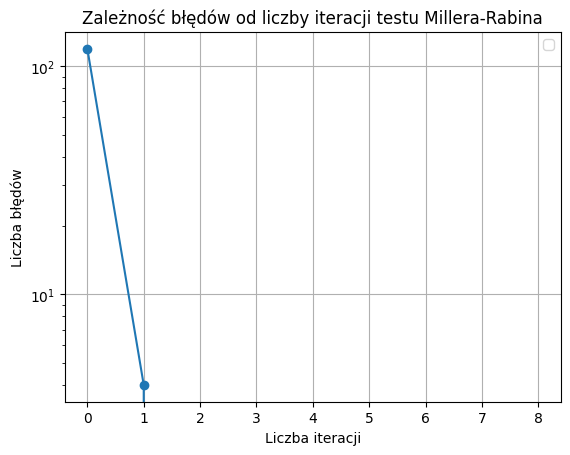

In [24]:
def miller_rabin_test(n, iter):
    d = n - 1
    s = 0

    while d % 2 == 0:
        d //= 2 
        s += 1

    def check_a(n, a, d, s):
        x = pow(a, d, mod=n) 

        if x == 1:
            return True
        
        for _ in range(s):
            if x == n - 1:
                return True
            x = pow(x, 2, n)
            
        return False

    for _ in range(iter):
        a = random.randrange(1, n)
        
        if not check_a(n, a, d, s):
            return False
        
    return True


def get_miller_rabin_test_errors(iter):
    false_positives = 0
    false_negatives = 0

    for i in range(2, SIZE):
        test_positive = miller_rabin_test(i, iter)
        if not prime_ref(i) and test_positive:
            false_positives += 1
        elif prime_ref(i) and not test_positive:
            false_negatives += 1
    
    return false_positives, false_negatives

false_positives, false_negatives = get_miller_rabin_test_errors(1)

print("Wyniki dla jednej iteracji testu:")
print(f"Fałszywe pozytywy: {false_positives}")
print(f"Fałszywe negatywy: {false_negatives}")

errors = []
for i in range(1, 10):
    false_positives, _ = get_miller_rabin_test_errors(i)
    errors.append(false_positives)

plt.plot(errors, marker="o")

plt.yscale('log')

plt.title('Zależność błędów od liczby iteracji testu Millera-Rabina')
plt.xlabel('Liczba iteracji')
plt.ylabel('Liczba błędów')

plt.grid()

plt.legend()
plt.show()

Aby mieć rozsądne szanse na zero niepoprawnych wyników wystarczy wykonać dwie iteracje.

## Generowanie liczb pierwszych

### Duże liczby pierwsze dla kryptografii

W swojej książce "Applied Cryptography" Bruce Schneier proponuje następujący algorytm generowania $n$-bitowych liczb pierwszych:

1. Wygeneruj losową liczbę $n$-bitową
2. Ustaw pierwszy i ostatni bit na $1$ (by zapewnić że jest duża i nieparzysta)
3. Sprawdź, czy wygenerowana liczba jest podzielna przez małe liczby pierwsze, np. wszystkie mniejsze niż $2000$
4. Przeprowadź dla wygenerowanej liczby test Millera-Rabina z $5$ iteracjami
5. Jeśli wygenerowana liczba nie przeszła któregoś z testów (3) i (4), wróć do (1)

#### Zadanie 3

1. Zaimplementuj opisany powyżej schemat generacji liczb pierwszych. Do generacji losowej liczby $k$-bitowej można wykorzystać funkcję `getrandbits` z modułu `random`.
2. Wygeneruj przy jego pomocy liczbę pierwszą o rozmiarze 2048 bitów

#### Rozwiązanie

In [25]:
small_prime_set = set()
for i in range(2, 2000):
    if PRIMES[i]:
        small_prime_set.add(i)

def generate_n_bit_num(n_bits):
    num = random.getrandbits(n_bits)
    num |= (1 << (n_bits - 1))
    num |= 1
    return num

def shneier_prime(n_bits):
    while True:
        n = generate_n_bit_num(n_bits)
        
        composite = False
        for p in small_prime_set:
            if n % p == 0:
                composite = True
                break
            
        if not composite and miller_rabin_test(n, 5):
            return n

print(f"Liczba pierwsza o rozmiarze 2048 bitów: {shneier_prime(2048)}")

Liczba pierwsza o rozmiarze 2048 bitów: 16269491803530160947801121345205063056049843057452808798194182384008982730737941106214030583828970880490267619524820682865050242190617282598657235742770606994186821355815632914196619832528919498668212729160872299101200187383551466185521588311764092557738991138758893116021744487225624809726813866248088170913834067205959896464335607253436745518678619966718669670760693293225702366313848505189368127864877924020898690189025555555218222929161057408817181922431215656305712939989717121005372101553691058296865959265833129244530375633347151160436329853190032082596930631722553206454389597622257346467204471235754647286831


### Jeszcze większe liczby pierwsze dla przyjemności

Największa znana obecnie ludzkości liczba pierwsza to $2^{136279841} - 1$, posiadająca ponad 40 milionów cyfr dziesiętnych. Podobnie jak większość największych znanych liczb pierwszych, jest ona **liczbą Mersenne'a**, tj. ma postać
$$
M_n = 2^n - 1
$$
dla pewnego $n$. Nie wszystkie takie liczby są liczbami pierwszymi - jeśli $M_n$ jest liczbą pierwszą, to $n$ też musi być liczbą pierwszą, ale nie jest to warunek wystarczający - np. $M_{11} = 2047 = 23 \times 89$. Dla liczb Mersenne'a istnieją niemniej specjalne metody testowania pierwszości znacznie bardziej wydajne niż testy pierwszości ogólnego przeznaczenia. Najbardziej wydajną znaną metodą jest **test Lucasa-Lehmera**.

Test Lucasa-Lehmera działa następująco: dla zadanej nieparzystej liczby pierwszej $p$ konstruujemy rekurencyjnie ciąg $S_k$ tak, że

- $S_0 = 4$
- $S_k = S_{k-1}^2 - 2$

Wówczas $M_p = 2^p - 1$ jest liczbą pierwszą wtedy i tylko wtedy, gdy $S_{p-2} \equiv 0 \pmod {M_p}$

#### Zadanie 4

1. Zaimplementuj test Lucasa-Lehmera
2. Sprawdź, czy $M_3$, $M_5$, $M_{17}$, $M_{23}$, $M_{41}$, $M_{61}$, $M_{109}$, $M_{127}$, $M_{2459}$, $M_{3217}$ są liczbami pierwszymi
3. Porównaj czas działania testu Lucasa-Lehmera do czasu działania pojedynczej iteracji testu Millera-Rabina dla $M_{23209}$
4. (**dodatkowe**) Spróbuj wyliczyć jak największą liczbę pierwszą w czasie dostępnym na laboratorium. *Uwaga*: algorytm można przyspieszyć zamieniając dzielenie modulo $M_p$ na operacje binarne korzystając z tożsamości $k \equiv (k \mod 2^p) + \lfloor k / 2^p \rfloor$ - szczegóły [na Wikipedii](https://en.wikipedia.org/wiki/Lucas%E2%80%93Lehmer_primality_test)

In [26]:
TO_TEST = [3, 5, 17, 23, 41, 61, 109, 127, 2459, 3217]

#### Rozwiązanie

In [27]:
import time

def lucas_lehmer_test(p):
    M = (1 << p) - 1
    s = 4
    for _ in range(p - 2):
        s = (s * s - 2) % M
    return s == 0

for x in TO_TEST:
    test_positive = lucas_lehmer_test(x)
    print(f"Liczba M_{x} {"jest" if test_positive else "nie jest"} liczbą pierwszą")

p = 23209

start = time.time()
lucas_lehmer_test(p)
end = time.time()
print(f"Czas testu Lucasa-Lehmera dla M_{p}: {(end - start):.2f} sekund")

start = time.time()
miller_rabin_test(2**p - 1, 1)
end = time.time()
print(f"Czas testu Millera-Rabina dla M_{p}: {(end - start):.2f} sekund")

Liczba M_3 jest liczbą pierwszą
Liczba M_5 jest liczbą pierwszą
Liczba M_17 jest liczbą pierwszą
Liczba M_23 nie jest liczbą pierwszą
Liczba M_41 nie jest liczbą pierwszą
Liczba M_61 jest liczbą pierwszą
Liczba M_109 nie jest liczbą pierwszą
Liczba M_127 jest liczbą pierwszą
Liczba M_2459 nie jest liczbą pierwszą
Liczba M_3217 jest liczbą pierwszą
Czas testu Lucasa-Lehmera dla M_23209: 37.16 sekund
Czas testu Millera-Rabina dla M_23209: 45.84 sekund


## Elementy odwrotne w $(\mathbb{Z}/n\mathbb{Z})^\times$

Standardowy algorytm Euklidesa pozwala nam obliczyć największy wspólny dzielnik liczb $a$, $b$. Jego działanie sprowadza się do obliczenia ciągu reszt z dzielenia:
$$
\begin{aligned}
r_0 &= a, r_1 = b \\
r_2 &= r_0 \mod r_1\\
r_3 &= r_1 \mod r_2\\
\ldots & \\
r_n &= r_{n-2} \mod r_{n-1} \\
\ldots &
\end{aligned}
$$
aż do momentu, gdy $r_n = 0$, wówczas $r_{n-1}$ to szukana wartość $d = (a, b)$. Z lematu Bézouta wiemy, że istnieją liczby całkowite $s$, $t$ takie, że $sa + tb = 1$. Rozszerzony algorytm Euklidesa pozwala nam je wyliczyć. Poza ciągiem $\{r_k\}$ obliczamy w nim również ciągi pomocnicze $\{s_k\}$, $\{t_k\}$ o własności
$$
s_k a + t_k b = r_k
$$
W każdej iteracji algorytmu mając dane wartości $s_{k-1}, t_{k-1}, r_{k-1}$ oraz $s_k, t_k, r_k$, możemy obliczyć $s_{k+1}, t_{k+1}, r_{k+1}$ w następupjący sposób. Wiemy, że $r_{k-1} = q r_k + r_{k+1}$ dla pewnego $q$, konkretnie $q = \lfloor r_{k - 1} / r_k\rfloor$. Stąd, $r_{k+1} = r_{k-1} - q r_k$. Skoro zaś
$$
r_{k-1} = s_{k-1} a + t_{k-1} b, \quad r_k = s_k a + t_k b
$$
to również
$$
\begin{aligned}
r_{k+1} &= s_{k-1} a + t_{k-1} b - q(s_k a + t_k b) \\&=
(s_{k-1} - q s_k)a + (t_{k-1} - q t_k) b
\end{aligned}
$$
a zatem możemy przyjąć $s_{k+1} = s_{k-1} - q s_k$ oraz $t_{k+1} = t_{k-1} - q t_k$. Ostatecznie mamy zatem
$$
\begin{aligned}
r_{k+1} &= r_{k-1} - q r_k \\
s_{k+1} &= s_{k-1} - q s_k \\
t_{k+1} &= t_{k-1} - q t_k \\
\end{aligned}
$$

Jeśli $(a, n) = 1$, to mając wyliczone rozszerzonym algorytmem Euklidesa liczby całkowite $s$, $t$ takie, że $sa + tn = 1$, możemy wyliczyć element odwrotny do $a$ w $\mathbb{Z} / n\mathbb{Z}$ jako $a^{-1} \equiv s \pmod n$, jako że $n$ dzieli $sa - 1 = tn$.

#### Zadanie 5

1. Zaimplementuj rozszerzony algorytm Euklidesa wyznaczający dla zadanych $a, b \in \mathbb{Z}$ wartość $(a, b)$ oraz $s, t \in \mathbb{Z}$ takie, że $sa + tb = (a, b)$.
2. Zaimplementuj funkcję znajdującą dla danego $a$ element odwrotny modulo $n$
3. Przetestuj działanie powyższej funkcji dla kilku dużych (np. $1024$ bitowych) modułów.

#### Rozwiązanie

In [29]:
def extended_euclides(a, b):
    r_prev = a
    r_cur = b
    s_prev = 1
    s_cur = 0
    t_prev = 0
    t_cur = 1

    while r_cur != 0:
        q = r_prev // r_cur
        r_next = r_prev - q * r_cur
        s_next = s_prev - q * s_cur 
        t_next = t_prev - q * t_cur
        
        r_prev = r_cur
        r_cur = r_next
        s_prev = s_cur
        s_cur = s_next
        t_prev = t_cur
        t_cur = t_next
    
    return r_prev, s_prev, t_prev

def mod_inverse(a, n):
    r, s, t = extended_euclides(a, n)

    if r != 1:
        return None
    else:
        a_inverse = s % n
        return a_inverse
    
for _ in range(5):
    a = shneier_prime(2048)
    n = shneier_prime(1024)
    a_inv = mod_inverse(a, n)
    print(f"a={a}")
    print(f"n={n}")
    print(f"a_inv={a_inv}\n")


a=26059335381271764513913807128091725855444516417578958725246841879241238765757528705846908629951768840048836091951569475800344060503230888204533285398412148392720554168079584422595953124619804211167981709145086038913864080026529347171803258931238825154120783566878297277083842049151984046014893654071721200631837657347144181571585177867491600655313662004293960956764569655607920418778222068542975270382357354847451289807840113142949685420311559413433298857352998983442948709037843840165863100812828469311834309944659106334106216461886579355370841912971556508210589424567901007131254779415853256172646095402671362012107
n=130395897758761070419490362085525493409368113397870329142737996595823208677115996413012736627578317182348351460370475072064056568280740590334521571226948160193405355133639476975154962528065897041862038000164633200374297546009211557774434692979996650148197768879320734595322576022346214473066833323643363997761
a_inv=12977626794114777589903866699903705114089331342166036743158253